# Import modules

In [4]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer

# Read data

In [8]:
path = "C:/Users/Rick/OneDrive/Information studies/Year 2/Master thesis 1 1/data/esdr_raw"
list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
read_sensor_raw_list = []
for f in list_of_files:
    read_sensor_raw_list.append(pd.read_csv(join(path, f)).set_index("EpochTime"))
display(read_sensor_raw_list[0].head())

read_smell_raw = pd.read_csv("data/smell_raw.csv").set_index("EpochTime")

metadata_df = pd.read_json("data/esdr_metadata.json")

read_smell_raw

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH
EpochTime,,,,,
1477891800,0.0,0.0,51.7,343.0,3.6
1477895400,0.0,0.0,52.7,351.0,3.5
1477899000,0.0,0.0,52.6,359.0,3.4
1477902600,0.0,0.0,48.3,5.0,2.1
1477906200,0.0,0.0,31.1,41.0,2.2


,skewed_latitude,skewed_longitude,smell_value,smell_description,feelings_symptoms,additional_comments,zipcode
EpochTime,,,,,,,
1477935134,40.4293,-79.8720,1,NaN,NaN,NaN,15221
1477935767,40.3624,-79.9749,1,NaN,NaN,NaN,15227
1477955141,40.3275,-79.9606,1,NaN,NaN,NaN,15236
1477956180,40.4252,-79.8956,2,Woodsmoke,NaN,NaN,15218
1477956293,40.4237,-79.8964,3,Wood smoke,NaN,NaN,15218
...,...,...,...,...,...,...,...
1642883321,40.5296,-80.0114,4,NaN,NaN,NaN,15237
1642884413,40.4767,-79.9233,5,Smelled like pain thinner,Cough,Happened this morning more than now,15206
1642884774,40.4426,-79.9436,3,Sulphur,NaN,NaN,15213


# General Data pre-processing SENSOR & SMELL (my own)

Basic data processing so that the smell and sensor data have location data for each datapoint and are distributed between 3 regions created by K-means clustering. 

In [9]:
timesteps = "1D"
def basic_preprocess_sensor_data(sensor_raw_list, smell_raw, timesteps):
    
    #adding location metadata to the sensors
    all_sensor_locations = pd.DataFrame()
    for df in sensor_raw_list:

        string = df.columns[0]
        feed_number = int(re.findall(r"\.feed_(\d+)\.", string)[0])
        location_metdata_for_df = metadata_df.loc[metadata_df['id'] == feed_number]
        df["latitude"] = float(location_metdata_for_df['latitude'])
        df["longitude"] = float(location_metdata_for_df['longitude'])
        all_sensor_locations = pd.concat([all_sensor_locations, df[["latitude","longitude"]]], axis=0, ignore_index=True)

    #merge location data to create 3 regions 
    smell_location = smell_raw[["skewed_latitude", "skewed_longitude"]]
    smell_location = smell_location.rename(columns={'skewed_latitude': 'latitude', 'skewed_longitude': 'longitude'})
    locations = pd.concat([all_sensor_locations, smell_location], axis=0, ignore_index=True)
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(locations)
    
    #Add region for sensordata and remove unnecassarey columns and change epochtime to datetime
    for df in sensor_raw_list:
        df["region"] = kmeans.predict([[df['latitude'].iloc[0], df['longitude'].iloc[0]]])[0]
        df.drop(['latitude', 'longitude'], axis = 1, inplace = True) 
        df.index = pd.to_datetime(df.index, unit="s", utc=True)
        df["datetime"] = df.index
    
    #add region for smell
    smell_raw = smell_raw.rename(columns={'skewed_latitude': 'latitude', 'skewed_longitude': 'longitude'})
    smell_raw["region"] = kmeans.predict(smell_raw[["latitude","longitude"]])
    smell_raw.index = pd.to_datetime(smell_raw.index, unit="s", utc=True)
    smell_raw.drop(['latitude', 'longitude'], axis = 1, inplace = True) 
    df_smell = smell_raw
    

    df_all_sensor = pd.DataFrame()
    for sensor_df in sensor_raw_list:
        
        df_all_sensor = pd.concat([sensor_df, df_all_sensor], axis=0, ignore_index=True)
        
    
    df_all_sensor.index = df_all_sensor["datetime"]
    df_all_sensor.drop(["datetime"], axis = 1, inplace = True)
  
    display(df_all_sensor)
    df_all_sensor.resample(timesteps, label="right").mean()
    
    
    display(df_all_sensor)
    display(df_smell)
    return df_all_sensor, df_smell

df_all_sensor, df_smell = basic_preprocess_sensor_data(read_sensor_raw_list, read_smell_raw, timesteps)

C:\Users\Rick\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Rick\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Rick\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Rick\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Rick\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\Rick\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X doe

,3.feed_5975.PM2_5,region,3.feed_11067.CO_PPB..3.feed_43.CO_PPB,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB,3.feed_11067.NO_PPB..3.feed_43.NO_PPB,3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3,3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG,3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH,...,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3,3.feed_24.PM10_UG_M3,3.feed_23.PM10_UG_M3,3.feed_23.CO_PPM..3.feed_23.CO_PPB,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH
datetime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 05:30:00+00:00,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 06:30:00+00:00,5.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 07:30:00+00:00,9.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 08:30:00+00:00,3.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 09:30:00+00:00,9.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 12:30:00+00:00,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-11-02 13:30:00+00:00,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-11-02 14:30:00+00:00,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


,3.feed_5975.PM2_5,region,3.feed_11067.CO_PPB..3.feed_43.CO_PPB,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB,3.feed_11067.NO_PPB..3.feed_43.NO_PPB,3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3,3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG,3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH,...,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3,3.feed_24.PM10_UG_M3,3.feed_23.PM10_UG_M3,3.feed_23.CO_PPM..3.feed_23.CO_PPB,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH
datetime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 05:30:00+00:00,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 06:30:00+00:00,5.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 07:30:00+00:00,9.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 08:30:00+00:00,3.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31 09:30:00+00:00,9.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 12:30:00+00:00,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-11-02 13:30:00+00:00,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-11-02 14:30:00+00:00,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


,smell_value,smell_description,feelings_symptoms,additional_comments,zipcode,region
EpochTime,,,,,,
2016-10-31 17:32:14+00:00,1,NaN,NaN,NaN,15221,2
2016-10-31 17:42:47+00:00,1,NaN,NaN,NaN,15227,1
2016-10-31 23:05:41+00:00,1,NaN,NaN,NaN,15236,0
2016-10-31 23:23:00+00:00,2,Woodsmoke,NaN,NaN,15218,2
2016-10-31 23:24:53+00:00,3,Wood smoke,NaN,NaN,15218,2
...,...,...,...,...,...,...
2022-01-22 20:28:41+00:00,4,NaN,NaN,NaN,15237,1
2022-01-22 20:46:53+00:00,5,Smelled like pain thinner,Cough,Happened this morning more than now,15206,1
2022-01-22 20:52:54+00:00,3,Sulphur,NaN,NaN,15213,1


### SENSOR Pre-Processing (Group the sensor data by x amount of hours and by region and create seperate columns for each occurence)

In [10]:
def group_sensors_by_hour(df_all_sensor, timesteps):
    grouped = df_all_sensor.groupby([pd.Grouper(freq=timesteps), 'region']).mean()

    # pivot the region index into columns
    pivoted = grouped.unstack(level=1)

    # flatten the column names to match desired format
    pivoted.columns = [f"{col}_region_{region}" for col, region in pivoted.columns]
    
    # drop columns with all NaN values
    pivoted = pivoted.dropna(axis=1, how='all')
    
    

    sensor_df = pivoted
    
    return sensor_df
    
    
sensor_df = group_sensors_by_hour(df_all_sensor, timesteps)
display(sensor_df)

,3.feed_5975.PM2_5_region_2,3.feed_11067.CO_PPB..3.feed_43.CO_PPB_region_2,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB_region_2,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB_region_2,3.feed_11067.NO_PPB..3.feed_43.NO_PPB_region_2,3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3_region_2,3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG_region_2,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_region_2,3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH_region_2,3.feed_3.PM10B_UG_M3..3.feed_3.PM10_640_UG_M3_region_2,...,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3_region_1,3.feed_24.PM10_UG_M3_region_0,3.feed_23.PM10_UG_M3_region_1,3.feed_23.CO_PPM..3.feed_23.CO_PPB_region_1,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3_region_1,3.feed_1.SO2_PPM_region_1,3.feed_1.H2S_PPM_region_1,3.feed_1.SIGTHETA_DEG_region_1,3.feed_1.SONICWD_DEG_region_1,3.feed_1.SONICWS_MPH_region_1
datetime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 00:00:00+00:00,5.736842,482.933333,10.405556,24.916667,14.444444,6.055556,54.915789,71.000000,2.036842,9.000000,...,5.684211,4.947368,6.736842,0.216667,2.684211,0.000368,0.000000,44.235294,134.647059,2.947059
2016-11-01 00:00:00+00:00,11.541667,258.860870,10.781818,13.639130,3.127273,11.541667,35.908333,138.875000,2.445833,30.541667,...,24.125000,19.541667,25.083333,0.391667,10.375000,0.000583,0.000125,44.245833,139.250000,2.366667
2016-11-02 00:00:00+00:00,20.625000,472.573913,12.578261,14.913043,2.286957,20.625000,25.858333,200.541667,3.462500,62.458333,...,31.750000,32.750000,42.541667,0.558333,15.375000,0.000304,0.000000,33.991667,147.125000,3.083333
2016-11-03 00:00:00+00:00,13.041667,457.430435,11.559091,16.508696,5.318182,13.041667,28.675000,229.416667,4.691667,31.250000,...,14.666667,13.875000,16.500000,0.183333,9.045455,0.000000,0.000000,34.291667,208.958333,4.433333
2016-11-04 00:00:00+00:00,5.916667,620.421739,10.921739,26.134783,15.139130,5.916667,47.462500,253.958333,2.654167,8.083333,...,8.625000,4.875000,7.458333,0.137500,1.958333,0.000000,0.000000,34.208333,299.666667,3.420833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07 00:00:00+00:00,9.079167,695.908696,11.813043,NaN,NaN,NaN,23.979167,232.250000,3.816667,21.112500,...,15.800000,23.913043,NaN,NaN,11.995833,NaN,NaN,NaN,NaN,NaN
2022-12-08 00:00:00+00:00,9.925000,717.552174,11.372727,NaN,NaN,NaN,37.091667,168.166667,2.400000,14.741667,...,15.004167,9.181818,NaN,NaN,12.329167,NaN,NaN,NaN,NaN,NaN
2022-12-09 00:00:00+00:00,10.079167,494.208696,8.462500,NaN,NaN,NaN,40.212500,71.416667,1.833333,14.695833,...,17.754167,9.791667,NaN,NaN,13.279167,NaN,NaN,NaN,NaN,NaN


## Data preproccesing (smell)

Aggregate data per day and create target variables.

C:\Users\Rick\AppData\Local\Temp\ipykernel_18784\3917911889.py:17: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df_bad_smell = pd.merge(df_bad_smell, pd.DataFrame(index=index), left_index=True, right_index=True, how='outer')
C:\Users\Rick\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


There are gaps in the index.


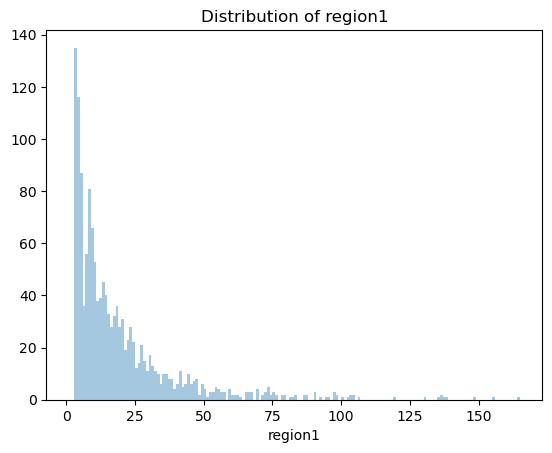

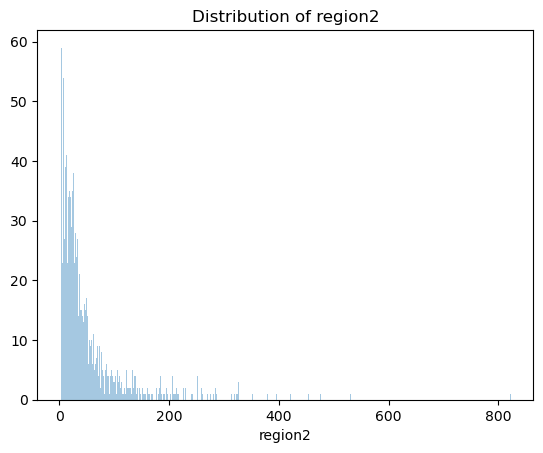

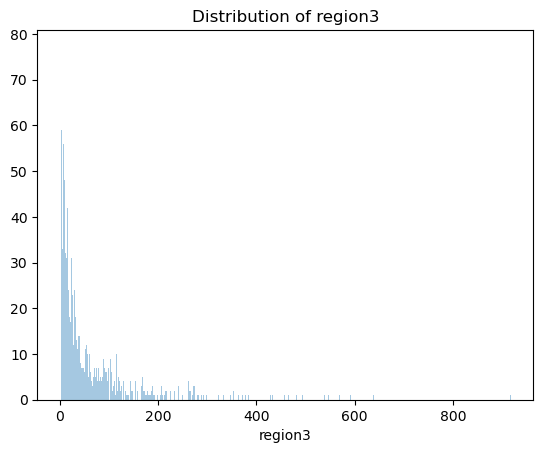

           region1      region2      region3
count  1416.000000  1838.000000  1791.000000
mean     19.489407    50.394450    65.774428
std      21.091419    63.517142    93.227681
min       3.000000     3.000000     3.000000
25%       6.000000    14.000000    12.000000
50%      13.000000    29.000000    29.000000
75%      24.000000    60.000000    84.000000
max     165.000000   823.000000   918.000000


,classification_region1,classification_region2,classification_region3
datetime,,,
2016-11-01 00:00:00+00:00,0,0,0
2016-11-02 00:00:00+00:00,0,1,1
2016-11-03 00:00:00+00:00,0,0,1
2016-11-04 00:00:00+00:00,0,0,0
2016-11-05 00:00:00+00:00,0,0,0
...,...,...,...
2022-01-19 00:00:00+00:00,0,0,0
2022-01-20 00:00:00+00:00,1,0,0
2022-01-21 00:00:00+00:00,0,0,0


In [11]:
def create_target_variables_from_smell(df_smell, timesteps):
    #filter on only bad air quality smell reports
    df_bad_smell = df_smell.copy()
    df_bad_smell = df_bad_smell[(df_bad_smell["smell_value"]>=3)&(df_bad_smell["smell_value"]<=5)]

    #round all smell reports to each day
    df_bad_smell.index = df_bad_smell.index.round(timesteps)
    #group and aggregate all smell reports for each day and take the sum smell reports for each day
    df_bad_smell = df_bad_smell.groupby([pd.Grouper(freq= timesteps), 'region']).agg({'smell_value': 'sum'})
    df_bad_smell = df_bad_smell.unstack(level='region')
 
    start_time = df_bad_smell.index.get_level_values('EpochTime').min().floor('H')
    end_time = df_bad_smell.index.get_level_values('EpochTime').max().floor('H')
    index = pd.date_range(start_time, end_time, freq= timesteps)

    # merge the existing DataFrame with the complete index using an outer join to see dates that don't have smell reports
    df_bad_smell = pd.merge(df_bad_smell, pd.DataFrame(index=index), left_index=True, right_index=True, how='outer')

    # check if there are any missing values
    if df_bad_smell.isna().sum().sum() > 0:
        print('There are gaps in the index.')
    else:
        print('There are no gaps in the index.')

    #reindex the DataFrame with the complete index and fill in the missing values
    df_bad_smell = df_bad_smell.reindex(index=index).fillna(pd.NA).reset_index()
    
    #reindex to the right format and fill in NaNs
    df_bad_smell = df_bad_smell.rename(columns={0: 'region1', 1: 'region2', 2: 'region3'})
    df_bad_smell.columns = ['EpochTime', 'region1', 'region2', 'region3']
    df_bad_smell = df_bad_smell.set_index('EpochTime')
    df_bad_smell.fillna(0, inplace=True)
    df_bad_smell['y'] = df_bad_smell.apply(lambda x: [x['region1'], x['region2'], x['region3']], axis=1)    
    df_bad_smell = df_bad_smell.copy()
    
    # create a list of the column names for each region
    regions = ['region1', 'region2', 'region3']

    # loop over each region and create a distribution plot
    for region in regions:
        sns.distplot(df_bad_smell[region], kde=False, bins=range(1, int(df_bad_smell[region].max() + 1)))
        plt.title(f'Distribution of {region}')
        plt.show()

    # Get the mean and median for each region and fill in empty values with value 0 
    df_bad_smell = df_bad_smell.replace(0, np.nan)
    # Print the results
    mean_by_region = df_bad_smell[['region1', 'region2', 'region3']].describe()
    print(mean_by_region)
    
    #getting the 75% quantile because the air quality is good for 75% of the time and bad for 25% of the time
    threshold_values = df_bad_smell[['region1', 'region2', 'region3']].quantile(q=0.75)
    threshold_region1 = threshold_values[0]
    threshold_region2 = threshold_values[1]
    threshold_region3 = threshold_values[2]

    # Define the threshold values for each region
    thresholds = {'region1': threshold_region1, 'region2': threshold_region2, 'region3': threshold_region3}

    for region in thresholds.keys():
        df_bad_smell[f'classification_{region}'] = np.where(df_bad_smell[region] >= thresholds[region], 1, 0)
    
    
    smell_df_y = df_bad_smell[['classification_region1', 'classification_region2', 'classification_region3']]
    smell_df_y.index.name = "datetime"
    
    return smell_df_y

df_smell_y = create_target_variables_from_smell(df_smell, "1D")
df_smell_y

# Feature Engineering

## SENSORS (Insert columns to indicate the data from the previous hours. )

In [15]:
def insert_previous_data_to_cols(df, n_hr=0):
    """
    Insert columns to indicate the data from the previous timestep.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed sensor data.
    n_hr : int
        Number of timesteps that we want to insert the previous sensor data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed sensor data.
    """
    # Copy data frame to prevent editing the original one.
    df = df.copy(deep=True)

    # Add the data from the previous hours.
    df_all = []
    for h in range(1, n_hr + 1):
        # Shift the data frame to get previous data.
        df_pre = df.shift(h)
        # Edit the name to indicate it is previous data.
        # The orginal data frame already has data from the previous 1 hour.
        # (as indicated in the preprocessing phase of sensor data)
        # So we need to add 1 here.
        df_pre.columns += "_pre_" + str(h+1) + "h"
        # Add the data to an array for merging.
        df_all.append(df_pre)

    # Rename the columns in the original data frame.
    # The orginal data frame already has data from the previous 1 hour.
    # (as indicated in the preprocessing phase of sensor data)
    df.columns += "_pre_1h"

    # Merge all data.
    df_merge = df
    for d in df_all:
        # The join function merges dataframes by index.
        df_merge = df_merge.join(d)
        
    # Delete the first n_hr rows.
    # These n_hr rows have no data due to data shifting.
    df_merge = df_merge.iloc[n_hr:]
    return df_merge


sensor_features = insert_previous_data_to_cols(sensor_df, n_hr=7)
sensor_features

,3.feed_5975.PM2_5_region_2_pre_1h,3.feed_11067.CO_PPB..3.feed_43.CO_PPB_region_2_pre_1h,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB_region_2_pre_1h,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB_region_2_pre_1h,3.feed_11067.NO_PPB..3.feed_43.NO_PPB_region_2_pre_1h,3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3_region_2_pre_1h,3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG_region_2_pre_1h,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_region_2_pre_1h,3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH_region_2_pre_1h,3.feed_3.PM10B_UG_M3..3.feed_3.PM10_640_UG_M3_region_2_pre_1h,...,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3_region_1_pre_8h,3.feed_24.PM10_UG_M3_region_0_pre_8h,3.feed_23.PM10_UG_M3_region_1_pre_8h,3.feed_23.CO_PPM..3.feed_23.CO_PPB_region_1_pre_8h,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3_region_1_pre_8h,3.feed_1.SO2_PPM_region_1_pre_8h,3.feed_1.H2S_PPM_region_1_pre_8h,3.feed_1.SIGTHETA_DEG_region_1_pre_8h,3.feed_1.SONICWD_DEG_region_1_pre_8h,3.feed_1.SONICWS_MPH_region_1_pre_8h
datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-07 00:00:00+00:00,9.043478,572.165217,16.290909,33.843478,18.590909,9.043478,46.900000,136.583333,1.283333,41.956522,...,5.684211,4.947368,6.736842,0.216667,2.684211,0.000368,0.000000,44.235294,134.647059,2.947059
2016-11-08 00:00:00+00:00,15.916667,669.260870,19.830435,33.752174,13.860870,15.916667,27.091667,154.250000,2.316667,33.791667,...,24.125000,19.541667,25.083333,0.391667,10.375000,0.000583,0.000125,44.245833,139.250000,2.366667
2016-11-09 00:00:00+00:00,16.333333,452.891304,10.591304,21.208696,10.613043,16.333333,31.733333,298.958333,4.450000,16.541667,...,31.750000,32.750000,42.541667,0.558333,15.375000,0.000304,0.000000,33.991667,147.125000,3.083333
2016-11-10 00:00:00+00:00,7.166667,371.930435,12.269565,19.347826,7.021739,7.166667,27.779167,258.958333,4.504167,12.166667,...,14.666667,13.875000,16.500000,0.183333,9.045455,0.000000,0.000000,34.291667,208.958333,4.433333
2016-11-11 00:00:00+00:00,6.291667,403.521739,9.256522,17.417391,8.113043,6.291667,32.766667,231.500000,6.058333,15.695652,...,8.625000,4.875000,7.458333,0.137500,1.958333,0.000000,0.000000,34.208333,299.666667,3.420833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07 00:00:00+00:00,9.079167,695.908696,11.813043,NaN,NaN,NaN,23.979167,232.250000,3.816667,21.112500,...,9.133333,9.250000,NaN,NaN,6.241667,NaN,NaN,NaN,NaN,NaN
2022-12-08 00:00:00+00:00,9.925000,717.552174,11.372727,NaN,NaN,NaN,37.091667,168.166667,2.400000,14.741667,...,13.504167,9.125000,NaN,NaN,8.158333,NaN,NaN,NaN,NaN,NaN
2022-12-09 00:00:00+00:00,10.079167,494.208696,8.462500,NaN,NaN,NaN,40.212500,71.416667,1.833333,14.695833,...,21.404348,32.818182,NaN,NaN,12.512500,NaN,NaN,NaN,NaN,NaN


## SMELL REPORTS (getting features from textual data using sentiment analysis and simple NLP) and (extracting time features from datetime)

In [16]:
def create_smell_features(df_smell, timesteps):
    #CREATE COPY AND REMOVE GOOD AIR QUALITY SMELL REPORTS
    df_smell_rounded = df_smell.copy()
    df_smell_rounded = df_smell_rounded[(df_smell_rounded["smell_value"]>=3)&(df_smell_rounded["smell_value"]<=5)]
    df_smell_rounded.index = df_smell_rounded.index.round(timesteps)

    #SENTIMENT ANALYSIS FOR NEGATIVE SCORE WHERE 0 IS NEUTRAL AND 1 IS MOST NEGATIVE POSSIBLE
    analyzer = SentimentIntensityAnalyzer()
    df_smell_rounded['all_text'] = df_smell_rounded['smell_description'].fillna('') + ' ' + df_smell_rounded['feelings_symptoms'].fillna('') + ' ' + df_smell_rounded['additional_comments'].fillna('')
    df_smell_rounded['overall_sentiment_score'] = df_smell_rounded['all_text'].apply(lambda x: analyzer.polarity_scores(str(x))['neg'])

    # Get the length of the 'smell_description', 'additional_comments' and 'feelings_symptoms' column
    df_smell_rounded["smell_description_length"] = df_smell_rounded['smell_description'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)
    df_smell_rounded["symptoms_description_length"] = df_smell_rounded['feelings_symptoms'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)
    df_smell_rounded["additional_comments_length"] = df_smell_rounded['additional_comments'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)
    df_smell_rounded["all_text_length"] = df_smell_rounded['all_text'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)

    #REMOVE UNWANTED TEXT COLUMNS
    df_smell_rounded = df_smell_rounded.drop(['smell_value', 'smell_description', 'feelings_symptoms', 'additional_comments', 'zipcode', 'all_text'] , axis=1)


    #AGGREGATE THE SUM AND MEAN FOR ALL COLUMNS AND DISTINGUISH BETWEEN EACH REGION
    # group the data by region and by 6-hour intervals, and compute the sum and mean for each group
    agg_df = df_smell_rounded.groupby([pd.Grouper(freq=timesteps), "region"]).agg({"overall_sentiment_score": ["sum", "mean"],
                                                                 "smell_description_length": ["sum", "mean"],
                                                                 "symptoms_description_length": ["sum", "mean"],
                                                                 "additional_comments_length": ["sum", "mean"],
                                                                 "all_text_length": ["sum", "mean"]})
    #FIX INDEX OF DATAFRAME
    agg_df = agg_df.reset_index()
    agg_df.columns = agg_df.columns.to_flat_index()
    agg_df.columns = [col[0] + '_' + col[1] if len(col) > 1 else col[0] for col in agg_df.columns]
    agg_df.set_index("EpochTime_", inplace=True)

    #FIX INDEX OF DATAFRAME WITH ADDING REGION ON COLUMNS
    agg_df = pd.pivot_table(agg_df, index="EpochTime_", columns="region_")
    agg_df.columns = agg_df.columns.to_flat_index()
    agg_df.columns = [col[0] + '_region' + str(col[1]) if len(col) > 1 else col[0] for col in agg_df.columns]
    agg_df = agg_df.fillna(0)
    
    #ADD ROWS FOR DAYS/HOURS THAT THERE HAVE NOT BEEN ANY SMELL REPORTS
    new_index = pd.date_range(start=min(agg_df.index), end=max(agg_df.index), freq=timesteps)
    agg_df = agg_df.reindex(new_index, fill_value=0)
    agg_df.index.name = "datetime"
    
    
    #ADD FEATURES FOR DATETIME
    datetime_index = new_index
    #agg_df['hour'] = datetime_index.hour
    agg_df['day'] = datetime_index.day
    agg_df['month'] = datetime_index.month
    agg_df['weekday'] = datetime_index.weekday
    agg_df['dayofyear'] = datetime_index.dayofyear
    agg_df['weekofyear'] = datetime_index.weekofyear
    agg_df['quarter'] = datetime_index.quarter
    return agg_df

smell_features = create_smell_features(df_smell, timesteps)
smell_features

C:\Users\Rick\AppData\Local\Temp\ipykernel_18784\1279922547.py:54: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  agg_df['weekofyear'] = datetime_index.weekofyear


,additional_comments_length_mean_region0,additional_comments_length_mean_region1,additional_comments_length_mean_region2,additional_comments_length_sum_region0,additional_comments_length_sum_region1,additional_comments_length_sum_region2,all_text_length_mean_region0,all_text_length_mean_region1,all_text_length_mean_region2,all_text_length_sum_region0,...,symptoms_description_length_mean_region2,symptoms_description_length_sum_region0,symptoms_description_length_sum_region1,symptoms_description_length_sum_region2,day,month,weekday,dayofyear,weekofyear,quarter
datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00+00:00,0.000000,160.000000,0.000000,0.0,320.0,0.0,0.000000,197.000000,12.000000,0.0,...,0.000000,0.0,48.0,0.0,1,11,1,306,44,4
2016-11-02 00:00:00+00:00,153.000000,19.925926,2.783784,153.0,538.0,103.0,196.000000,60.333333,28.810811,196.0,...,2.621622,15.0,452.0,97.0,2,11,2,307,44,4
2016-11-03 00:00:00+00:00,0.000000,27.666667,18.409091,0.0,415.0,405.0,0.000000,67.066667,46.090909,0.0,...,6.954545,0.0,194.0,153.0,3,11,3,308,44,4
2016-11-04 00:00:00+00:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,32.500000,39.000000,0.0,...,17.000000,0.0,23.0,17.0,4,11,4,309,44,4
2016-11-05 00:00:00+00:00,45.000000,82.750000,0.000000,45.0,331.0,0.0,57.000000,124.500000,24.500000,57.0,...,0.000000,0.0,78.0,0.0,5,11,5,310,44,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19 00:00:00+00:00,0.000000,4.714286,0.000000,0.0,33.0,0.0,12.500000,17.857143,7.000000,25.0,...,0.000000,0.0,40.0,0.0,19,1,2,19,3,1
2022-01-20 00:00:00+00:00,11.000000,0.000000,0.000000,66.0,0.0,0.0,25.666667,9.666667,16.250000,154.0,...,11.000000,7.0,0.0,44.0,20,1,3,20,3,1
2022-01-21 00:00:00+00:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,15.000000,0.000000,41.000000,45.0,...,34.400000,0.0,0.0,172.0,21,1,4,21,3,1


# Check and Export dataframe

In [17]:
def check_missing_time_intervals(df):

    # create a new DataFrame that contains all possible 6-hour intervals
    start_time = df.index.min()
    end_time = df.index.max()
    six_hour_intervals = pd.date_range(start=start_time, end=end_time, freq='1D')
    df_all_intervals = pd.DataFrame({'datetime': six_hour_intervals})

    # merge the two DataFrames
    merged_df = pd.merge(df_all_intervals, df, on='datetime', how='left')

    # check if there are any missing intervals
    if merged_df.isnull().values.any():
        return "There are missing intervals."
    else:
        return "There are no missing intervals."

    

#Check for each dataframe if there are missing timestamps 
print(check_missing_time_intervals(df_smell_y))    
print(check_missing_time_intervals(smell_features)) 
print(check_missing_time_intervals(sensor_features))

#display all dataframes and their length
display(df_smell_y)
display(smell_features)
display(sensor_features)


def merge_normalize_and_export_all_data(smell, sensor, target): 
    
    #merge all dataframes together 
    merged_df = smell.merge(sensor, on='datetime', how='inner').merge(target, on='datetime', how='inner')
    
    #index to split between training and test set
    split_index = int(len(merged_df) * 0.9)
    
    # Split data into training and test sets
    train_df = merged_df[:split_index]
    test_df = merged_df[split_index:]

    # Separate the target variables from the features
    train_features = train_df.drop(columns=['classification_region1', 'classification_region2', 'classification_region3'])
    train_targets = train_df[['classification_region1', 'classification_region2', 'classification_region3']]

    test_features = test_df.drop(columns=['classification_region1', 'classification_region2', 'classification_region3'])
    test_targets = test_df[['classification_region1', 'classification_region2', 'classification_region3']]

    # Normalize the training set features
    scaler = StandardScaler()
    train_features_normalized = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)
    train_features_normalized = train_features_normalized.set_index(train_features.index)

    # Normalize the test set features using training set parameters
    test_features_normalized = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)
    test_features_normalized = test_features_normalized.set_index(test_features.index)

    # Combine normalized features with target variables
    train_df_normalized = pd.concat([train_features_normalized, train_targets], axis=1)
    test_df_normalized = pd.concat([test_features_normalized, test_targets], axis=1)

    
    # Fill in missing NaN values from sensors with -1
    train_df_normalized = train_df_normalized.fillna(-1)
    test_df_normalized = test_df_normalized.fillna(-1)
    
    #export training dataframe to "preprocesseddata.csv"
    train_df_normalized.to_csv('preprocesseddata.csv', index = True, encoding='utf-8')
    #export test dataframe to "test_preprocesseddata.csv"
    test_df_normalized.to_csv('test_preprocesseddata.csv', index = True, encoding='utf-8')
    
    # Merge the normalized training and test data back together
    merged_df_normalized = pd.concat([train_df_normalized, test_df_normalized])

    display(test_df_normalized)
    print("Data has been merged, normalized, and exported.")
    
merge_normalize_and_export_all_data(smell_features, sensor_features, df_smell_y)

There are no missing intervals.
There are no missing intervals.
There are missing intervals.


,classification_region1,classification_region2,classification_region3
datetime,,,
2016-11-01 00:00:00+00:00,0,0,0
2016-11-02 00:00:00+00:00,0,1,1
2016-11-03 00:00:00+00:00,0,0,1
2016-11-04 00:00:00+00:00,0,0,0
2016-11-05 00:00:00+00:00,0,0,0
...,...,...,...
2022-01-19 00:00:00+00:00,0,0,0
2022-01-20 00:00:00+00:00,1,0,0
2022-01-21 00:00:00+00:00,0,0,0


,additional_comments_length_mean_region0,additional_comments_length_mean_region1,additional_comments_length_mean_region2,additional_comments_length_sum_region0,additional_comments_length_sum_region1,additional_comments_length_sum_region2,all_text_length_mean_region0,all_text_length_mean_region1,all_text_length_mean_region2,all_text_length_sum_region0,...,symptoms_description_length_mean_region2,symptoms_description_length_sum_region0,symptoms_description_length_sum_region1,symptoms_description_length_sum_region2,day,month,weekday,dayofyear,weekofyear,quarter
datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00+00:00,0.000000,160.000000,0.000000,0.0,320.0,0.0,0.000000,197.000000,12.000000,0.0,...,0.000000,0.0,48.0,0.0,1,11,1,306,44,4
2016-11-02 00:00:00+00:00,153.000000,19.925926,2.783784,153.0,538.0,103.0,196.000000,60.333333,28.810811,196.0,...,2.621622,15.0,452.0,97.0,2,11,2,307,44,4
2016-11-03 00:00:00+00:00,0.000000,27.666667,18.409091,0.0,415.0,405.0,0.000000,67.066667,46.090909,0.0,...,6.954545,0.0,194.0,153.0,3,11,3,308,44,4
2016-11-04 00:00:00+00:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,32.500000,39.000000,0.0,...,17.000000,0.0,23.0,17.0,4,11,4,309,44,4
2016-11-05 00:00:00+00:00,45.000000,82.750000,0.000000,45.0,331.0,0.0,57.000000,124.500000,24.500000,57.0,...,0.000000,0.0,78.0,0.0,5,11,5,310,44,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19 00:00:00+00:00,0.000000,4.714286,0.000000,0.0,33.0,0.0,12.500000,17.857143,7.000000,25.0,...,0.000000,0.0,40.0,0.0,19,1,2,19,3,1
2022-01-20 00:00:00+00:00,11.000000,0.000000,0.000000,66.0,0.0,0.0,25.666667,9.666667,16.250000,154.0,...,11.000000,7.0,0.0,44.0,20,1,3,20,3,1
2022-01-21 00:00:00+00:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,15.000000,0.000000,41.000000,45.0,...,34.400000,0.0,0.0,172.0,21,1,4,21,3,1


,3.feed_5975.PM2_5_region_2_pre_1h,3.feed_11067.CO_PPB..3.feed_43.CO_PPB_region_2_pre_1h,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB_region_2_pre_1h,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB_region_2_pre_1h,3.feed_11067.NO_PPB..3.feed_43.NO_PPB_region_2_pre_1h,3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3_region_2_pre_1h,3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG_region_2_pre_1h,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_region_2_pre_1h,3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH_region_2_pre_1h,3.feed_3.PM10B_UG_M3..3.feed_3.PM10_640_UG_M3_region_2_pre_1h,...,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3_region_1_pre_8h,3.feed_24.PM10_UG_M3_region_0_pre_8h,3.feed_23.PM10_UG_M3_region_1_pre_8h,3.feed_23.CO_PPM..3.feed_23.CO_PPB_region_1_pre_8h,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3_region_1_pre_8h,3.feed_1.SO2_PPM_region_1_pre_8h,3.feed_1.H2S_PPM_region_1_pre_8h,3.feed_1.SIGTHETA_DEG_region_1_pre_8h,3.feed_1.SONICWD_DEG_region_1_pre_8h,3.feed_1.SONICWS_MPH_region_1_pre_8h
datetime,,,,,,,,,,,,,,,,,,,,,
2016-11-07 00:00:00+00:00,9.043478,572.165217,16.290909,33.843478,18.590909,9.043478,46.900000,136.583333,1.283333,41.956522,...,5.684211,4.947368,6.736842,0.216667,2.684211,0.000368,0.000000,44.235294,134.647059,2.947059
2016-11-08 00:00:00+00:00,15.916667,669.260870,19.830435,33.752174,13.860870,15.916667,27.091667,154.250000,2.316667,33.791667,...,24.125000,19.541667,25.083333,0.391667,10.375000,0.000583,0.000125,44.245833,139.250000,2.366667
2016-11-09 00:00:00+00:00,16.333333,452.891304,10.591304,21.208696,10.613043,16.333333,31.733333,298.958333,4.450000,16.541667,...,31.750000,32.750000,42.541667,0.558333,15.375000,0.000304,0.000000,33.991667,147.125000,3.083333
2016-11-10 00:00:00+00:00,7.166667,371.930435,12.269565,19.347826,7.021739,7.166667,27.779167,258.958333,4.504167,12.166667,...,14.666667,13.875000,16.500000,0.183333,9.045455,0.000000,0.000000,34.291667,208.958333,4.433333
2016-11-11 00:00:00+00:00,6.291667,403.521739,9.256522,17.417391,8.113043,6.291667,32.766667,231.500000,6.058333,15.695652,...,8.625000,4.875000,7.458333,0.137500,1.958333,0.000000,0.000000,34.208333,299.666667,3.420833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-07 00:00:00+00:00,9.079167,695.908696,11.813043,NaN,NaN,NaN,23.979167,232.250000,3.816667,21.112500,...,9.133333,9.250000,NaN,NaN,6.241667,NaN,NaN,NaN,NaN,NaN
2022-12-08 00:00:00+00:00,9.925000,717.552174,11.372727,NaN,NaN,NaN,37.091667,168.166667,2.400000,14.741667,...,13.504167,9.125000,NaN,NaN,8.158333,NaN,NaN,NaN,NaN,NaN
2022-12-09 00:00:00+00:00,10.079167,494.208696,8.462500,NaN,NaN,NaN,40.212500,71.416667,1.833333,14.695833,...,21.404348,32.818182,NaN,NaN,12.512500,NaN,NaN,NaN,NaN,NaN


,additional_comments_length_mean_region0,additional_comments_length_mean_region1,additional_comments_length_mean_region2,additional_comments_length_sum_region0,additional_comments_length_sum_region1,additional_comments_length_sum_region2,all_text_length_mean_region0,all_text_length_mean_region1,all_text_length_mean_region2,all_text_length_sum_region0,...,3.feed_23.CO_PPM..3.feed_23.CO_PPB_region_1_pre_8h,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3_region_1_pre_8h,3.feed_1.SO2_PPM_region_1_pre_8h,3.feed_1.H2S_PPM_region_1_pre_8h,3.feed_1.SIGTHETA_DEG_region_1_pre_8h,3.feed_1.SONICWD_DEG_region_1_pre_8h,3.feed_1.SONICWS_MPH_region_1_pre_8h,classification_region1,classification_region2,classification_region3
datetime,,,,,,,,,,,,,,,,,,,,,
2021-07-17 00:00:00+00:00,3.082124,-0.237506,-0.632081,0.655377,-0.454489,-0.533715,2.660870,-0.363248,-0.388898,0.270174,...,-1.0,0.205355,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0
2021-07-18 00:00:00+00:00,-0.460939,-0.535597,-0.632081,-0.414837,-0.655309,-0.533715,-0.851161,-0.753535,-1.248714,-0.543110,...,-1.0,0.476099,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0
2021-07-19 00:00:00+00:00,0.496646,-0.336870,-0.632081,-0.125590,-0.566056,-0.533715,1.058422,-0.607602,-0.114194,-0.100906,...,-1.0,-0.218812,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0
2021-07-20 00:00:00+00:00,-0.460939,-0.472764,-0.144067,-0.414837,-0.535375,-0.342499,-0.797746,-0.527947,-0.005105,-0.536926,...,-1.0,-0.318085,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,0
2021-07-21 00:00:00+00:00,0.123188,-0.082941,-0.321198,-0.061956,0.259537,-0.229185,-0.076645,-0.038574,0.675607,-0.184399,...,-1.0,-0.263936,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19 00:00:00+00:00,-0.460939,-0.418490,-0.632081,-0.414837,-0.563267,-0.533715,-0.517318,-0.641055,-1.019629,-0.465802,...,-1.0,-0.489557,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0
2022-01-20 00:00:00+00:00,-0.039601,-0.535597,-0.632081,-0.033031,-0.655309,-0.533715,-0.165670,-0.807836,-0.716908,-0.066890,...,-1.0,1.044663,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,0
2022-01-21 00:00:00+00:00,-0.460939,-0.535597,-0.632081,-0.414837,-0.655309,-0.533715,-0.450549,-1.004677,0.093075,-0.403955,...,-1.0,1.102736,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0


Data has been merged, normalized, and exported.


In [9]:
# def compute_feature_label(df_smell, df_sensor, b_hr_sensor=0, f_hr_smell=0):
#     """
#     Compute features and labels from the smell and sensor data.
    
#     Parameters
#     ----------
#     df_smell : pandas.DataFrame
#         The preprocessed smell data.
#     df_sensor : pandas.DataFrame
#         The preprocessed sensor data.
#     b_hr_sensor : int
#         Number of hours that we want to insert the previous sensor data.
#     f_hr_smell : int
#         Number of hours that we want to sum up the future smell data.
    
#     Returns
#     -------
#     df_x : pandas.DataFrame
#         The features that we want to use for modeling.
#     df_y : pandas.DataFrame
#         The labels that we want to use for modeling.
#     """
    
#     # Insert previous sensor data as features.
#     # Noice that the df_sensor is already using the previous data.
#     # So b_hr_sensor=0 means using data from the previous 1 hour.
#     # And b_hr_sensor=n means using data from the previous n+1 hours.
#     df_sensor = insert_previous_data_to_cols(df_sensor, b_hr_sensor)
    
#     # Sum up current and future smell values as label.
#     # Notice that the df_smell is already the data from the future 1 hour.
#     # (as indicated in the preprocessing phase of smell data)
#     # So f_hr_smell=0 means using data from the future 1 hour.
#     # And f_hr_smell=n means using data from the future n+1 hours.
#     df_smell = answer_sum_current_and_future_data(df_smell, f_hr_smell)
    
#     # Add suffix to the column name of the smell data to prevent confusion.
#     # See the description above for the reason of adding 1 to the f_hr_smell.
#     df_smell.columns += "_future_" + str(f_hr_smell+1) + "h"